# 10 - Step-by-step NMO correction

Devito is equally useful as a framework for other stencil computations in general; for example, computations where all array indices are affine functions of loop variables. The Devito compiler is also capable of generating
arbitrarily nested, possibly irregular, loops. This key feature is needed to support many complex algorithms that are used in engineering and scientific practice, including applications from image processing, cellular automata, and machine-learning. This tutorial, a step-by-step NMO correction, is an example of it.  

In reflection seismology, normal moveout (NMO) describes the effect that the distance between a seismic source and a receiver (the offset) has on the arrival time of a reflection in the form of an increase of time with offset. The relationship between arrival time and offset is hyperbolic. 

Based on the field geometry information, each individual trace is assigned to the midpoint between the shot and receiver locations associated with that trace. Those traces with the same midpoint location are grouped together, making up a common midpoint gather (CMP). 

Consider a reflection event on a CMP gather. The difference between the two-way time at a given offset and the two-way zero-offset time is called normal moveout (NMO). Reflection traveltimes must be corrected for NMO prior to summing the traces in the CMP gather along the offset axis. The normal moveout depends on velocity above the reflector, offset, two-way zero-offset time associated with the reflection event, dip of the reflector, the source-receiver azimuth with respect to the true-dip direction, and the degree of complexity of the near-surface and the medium above the reflector.

<img src='./nmo-diagram.png' width=1000>


# Seismic modelling with devito

Before the NMO correction we will describe a setup of seismic modelling with Devito in a simple 2D case. We will create a physical model of our domain and define a multiple source and an according set of receivers to model for the forward model. But first, we initialize some basic utilities.

In [1]:
import numpy as np
import sympy as sp

from devito import *

We will create a simple velocity model here by hand for demonstration purposes. This model essentially consists of three layers, each with a different velocity: 1.5km/s in the top layer, 2.5km/s in the middle layer and 4.5 km/s in the bottom layer.

NUMA domain count autodetection failed, assuming 1
Operator `initdamp` ran in 0.01 s


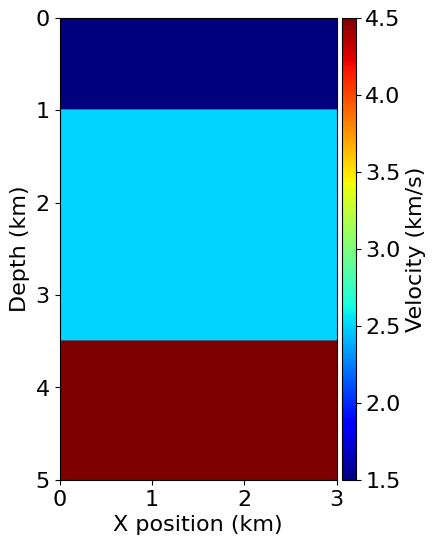

In [2]:
# NBVAL_IGNORE_OUTPUT
from examples.seismic import Model, plot_velocity

shape = (301, 501)  # Number of grid point (nx, ny, nz)
spacing = (10., 10)  # Grid spacing in m. The domain size is now 3km by 5km
origin = (0., 0)  # What is the location of the top left corner.

# Define a velocity profile. The velocity is in km/s
v = np.empty(shape, dtype=np.float32)
v[:, :100] = 1.5
v[:, 100:350] = 2.5
v[:, 350:] = 4.5

# With the velocity and model size defined, we can create the seismic model that
# encapsulates these properties. We also define the size of the absorbing layer as 10 grid points
model = Model(vp=v, origin=origin, shape=shape, spacing=spacing, space_order=4, nbl=40, bcs="damp")

plot_velocity(model)

Next we define the positioning and the wave signal of our source, as well as the location of our receivers. To generate the wavelet for our sources we require the discretized values of time that we are going to use to model a multiple "shot", which depends on the grid spacing used in our model. We will use one source and eleven receivers. The source is located in the position (550, 20). The receivers start at (550, 20) with an even horizontal spacing of 100m at consistent depth.

In [3]:
from examples.seismic import TimeAxis

t0 = 0.  # Simulation starts a t=0
tn = 2400.  # Simulation last 2.4 second (2400 ms)
dt = model.critical_dt  # Time step from model grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)

nrcv = 250  # Number of Receivers

In [4]:
# NBVAL_IGNORE_OUTPUT
from examples.seismic import RickerSource

f0 = 0.010  # Source peak frequency is 10Hz (0.010 kHz)
src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=1, time_range=time_range)

# Define the wavefield with the size of the model and the time dimension
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=4)

# We can now write the PDE
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))

src.coordinates.data[:, 0] = 400  # Source coordinates
src.coordinates.data[:, -1] = 20.  # Depth is 20m

In [5]:
# NBVAL_IGNORE_OUTPUT
from examples.seismic import Receiver

rec = Receiver(name='rec', grid=model.grid, npoint=nrcv, time_range=time_range)
rec.coordinates.data[:, 0] = np.linspace(src.coordinates.data[0, 0], model.domain_size[0], num=nrcv)
rec.coordinates.data[:, -1] = 20.  # Depth is 20m

# Finally we define the source injection and receiver read function to generate the corresponding code
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)

# Create interpolation expression for receivers
rec_term = rec.interpolate(expr=u.forward)

op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)
op(time=time_range.num-1, dt=model.critical_dt)

Operator `Kernel` ran in 0.21 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.17288500000000065, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.01466000000000027, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.01618600000000005, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

How we are modelling a horizontal layers, we will group this traces and made a NMO correction using this set traces. 

In [6]:
offset = []
data = []
for i, coord in enumerate(rec.coordinates.data):
    off = (src.coordinates.data[0, 0] - coord[0])
    offset.append(off)
    data.append(rec.data[:, i])

Auxiliary function for plotting traces:

In [7]:
# NBVAL_IGNORE_OUTPUT
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

mpl.rc('font', size=16)
mpl.rc('figure', figsize=(8, 6))


def plot_traces(rec, xb, xe, t0, tn, colorbar=True):
    scale = np.max(rec)/100
    extent = [xb, xe, 1e-3*tn, t0]
    plot = plt.imshow(rec, cmap=cm.gray, vmin=-scale, vmax=scale, extent=extent)
    plt.xlabel('X position (km)')
    plt.ylabel('Time (s)')

    # Create aligned colorbar on the right
    if colorbar:
        ax = plt.gca()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(plot, cax=cax)
    plt.show()

# Common Midpoint Gather

At this point, we have a dataset composed of the receivers. "If our model wasn't purely horizontal, we would have to sort these traces by common midpoints prior to NMO correction."

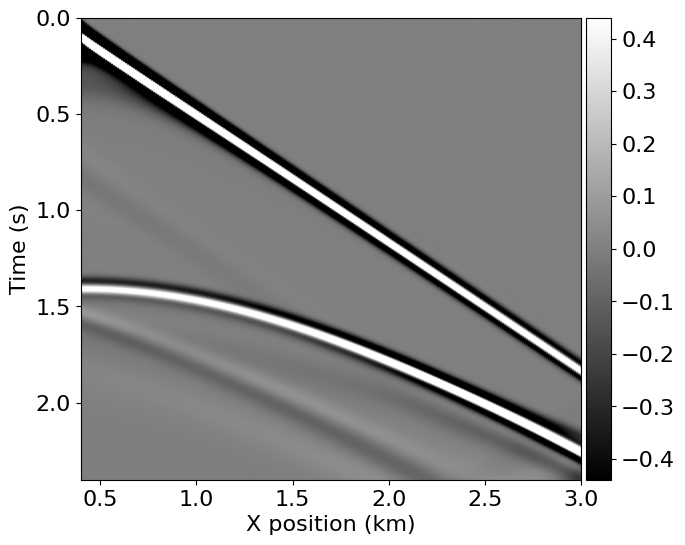

In [8]:
# NBVAL_IGNORE_OUTPUT
plot_traces(np.transpose(data), rec.coordinates.data[0][0]/1000, rec.coordinates.data[nrcv-1][0]/1000, t0, tn)


# NMO Correction

We can correct the measured traveltime of a reflected wave $t$ at a given offset $x$ to obtain the traveltime at normal incidence $t_0$ by applying the following equation:

\begin{equation*}
t = \sqrt{t_0^2 + \frac{x^2}{V_{nmo}^2}} 
\end{equation*}

in which $V_{nmo}$ is the NMO velocity. This equation results from the Pythagorean theorem, and is only valid for horizontal reflectors. There are variants of this equation with different degrees of accuracy, but we'll use this one for simplicity.

For the NMO Correction we use a grid of size samples x traces.

In [9]:
ns = time_range.num  # Number of samples in each trace
grid = Grid(shape=(ns, nrcv))  # Construction of grid with samples X traces dimension

In this example we will use a constant velocity guide. The guide will be arranged in a SparseFunction with the number of points equal to number of samples in the traces. 

In [10]:
vnmo = 1500
vguide = SparseFunction(name='v', grid=grid, npoint=ns)
vguide.data[:] = vnmo

The computed offset for each trace will be arranged in another SparseFunction with number of points equal to number of traces.

In [11]:
off = SparseFunction(name='off', grid=grid, npoint=nrcv)
off.data[:] = offset

The previous modelled traces will be arranged in a SparseFunction with the same dimensions as the grid.

In [12]:
amps = SparseFunction(name='amps', grid=grid, npoint=nrcv, dimensions=grid.dimensions, shape=grid.shape)
amps.data[:] = np.transpose(data)

Now, we define SparseFunctions with the same dimensions as the grid, describing the NMO traveltime equation. The $t_0$ SparseFunction isn't offset dependent, so the number of points is equal to the number of samples. 

In [13]:
sample, trace = grid.dimensions

t_0 = SparseFunction(name='t0', grid=grid, npoint=ns, dimensions=[sample], shape=[grid.shape[0]])
tt = SparseFunction(name='tt', grid=grid, npoint=nrcv, dimensions=grid.dimensions, shape=grid.shape)
snmo = SparseFunction(name='snmo', grid=grid, npoint=nrcv, dimensions=grid.dimensions, shape=grid.shape)
s = SparseFunction(name='s', grid=grid, dtype=np.intc, npoint=nrcv, dimensions=grid.dimensions,
                   shape=grid.shape)

The Equation relates traveltimes: the one we can measure ($t_0$) and the one we want to know (t). But the data in our CMP gather are actually a matrix of amplitudes measured as a function of time ($t_0$) and offset. Our NMO-corrected gather will also be a matrix of amplitudes as a function of time (t) and offset. So what we really have to do is transform one matrix of amplitudes into the other.

With Equations we describe the NMO traveltime equation, and use the Operator to compute the traveltime and the samples for each trace. 

In [14]:
# NBVAL_IGNORE_OUTPUT

dtms = model.critical_dt/1000  # Time discretization in ms
E1 = Eq(t_0, sample*dtms)
E2 = Eq(tt, sp.sqrt(t_0**2 + (off[trace]**2)/(vguide[sample]**2)))
E3 = Eq(s, sp.floor(tt/dtms))
op1 = Operator([E1, E2, E3])
op1()

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.000166, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

With the computed samples, we remove all that are out of the samples range, and shift the amplitude for the correct sample. 

Operator `Kernel` ran in 0.01 s


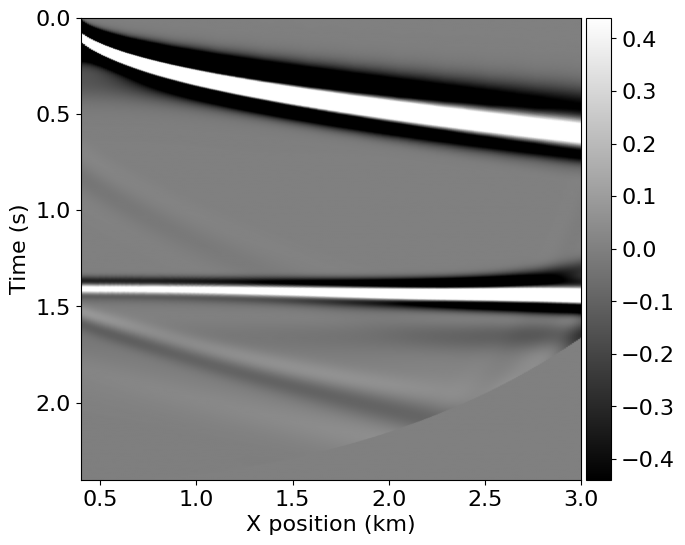

In [15]:
# NBVAL_IGNORE_OUTPUT

s.data[s.data >= time_range.num] = 0
E4 = Eq(snmo, amps[s[sample, trace], trace])

op2 = Operator([E4])
op2()

stack = snmo.data.sum(axis=1)  # We can stack traces and create a ZO section!!!

plot_traces(snmo.data, rec.coordinates.data[0][0]/1000, rec.coordinates.data[nrcv-1][0]/1000, t0, tn)

# References:
    
    https://library.seg.org/doi/full/10.1190/tle36020179.1
    https://wiki.seg.org/wiki/Normal_moveout
    https://en.wikipedia.org/wiki/Normal_moveout